<div style="text-align: center">
  <h1>Customer Churn Prediction Using Machine Learning</h1>
  <p><em>Author: Marta Rares</em></p>
</div>

## Problem Context

This project addresses the challenge of predicting customer churn for a financial institution. Customer churn refers to the event in which a client ceases their relationship with the bank. Proactively identifying customers at risk of churning enables strategic interventions, retention efforts, and improved resource allocation.

The goal is to build a binary classification model that estimates the probability of churn (`Exited = 1`) for each customer, using demographic, financial, and behavioral data.

## Dataset Description

The dataset contains structured information about individual bank customers and is split into two files:

- `train.csv`: 15k rows of customer data, including the target column `Exited` (0 = retained, 1 = churned).
- `test.csv`: 10k rows, `Exited` column excluded.
- `sample_submission.csv`: Shows the required format for submitting predictions (`id`, `Exited`) as probabilities.

## Features

The dataset includes the following columns:

- **CustomerId**: Unique ID for each customer.
- **Surname**: Customer’s surname.
- **CreditScore**: Credit score of the customer.
- **Geography**: Country of residence (France, Spain, Germany).
- **Gender**: Customer’s gender.
- **Age**: Age in years.
- **Tenure**: Number of years as a customer.
- **Balance**: Bank account balance.
- **NumOfProducts**: Number of bank products the customer is using.
- **HasCrCard**: Whether the customer owns a credit card (1 = Yes, 0 = No).
- **IsActiveMember**: Whether the customer is an active member (1 = Yes, 0 = No).
- **EstimatedSalary**: Estimated annual income of the customer.
- **Exited** *(target variable)*: Indicates whether the customer left the bank (1) or not (0).

## Objective

Develop a machine learning model that:
- Accurately predicts the likelihood of each customer in `test.csv` churning.
- Outputs a `submission.csv` file containing the `id` and the predicted probability of `Exited`.

Model performance will be evaluated using the **Area Under the ROC Curve (AUC-ROC)** score.


<div style="text-align: center">
    <h1>Imports Libraries</h1>
</div>

In [ ]:
import os
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model Selection
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split
)

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)

# Classifiers
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

<div style="text-align: center">
    <h1>Import Datasets</h1>
</div>

In [44]:
# file paths
train_path = './dataset/train.csv'
test_path  = './dataset/test.csv'

def import_dataset(path, v=True):
    df = pd.read_csv(path)

    # Print basic information about the dataset
    file_name = os.path.basename(path)
    if v: print(f"[{file_name}] shape: {df.shape}")
    
    return df

<div style="text-align: center">
    <h1>Data Analysis</h1>
</div>

In [45]:
df_train = import_dataset(train_path)
display(df_train.head(3))

df_test = import_dataset(test_path)
display(df_test.head(3))

def display_df_info(df):
    print(f"Duplicated rows: {df.duplicated().sum().sum()}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    unique_values = df.nunique()
    data_types    = df.dtypes
    table = pd.DataFrame({
        "Column": unique_values.index,
        "Type": data_types.values,
        "Unique Values": unique_values.values
    })
    display(table)

print("\nTrain DataFrame Info:")
display_df_info(df_train)
print("\nTest DataFrame Info:")
display_df_info(df_test)

[train.csv] shape: (15000, 14)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15576945.0,Liao,585.0,France,Female,42.0,7.0,0.00,2.0,1.0,1.0,129984.20,0.0
1,1,15627212.0,Lettiere,756.0,Germany,Female,52.0,7.0,133801.04,3.0,0.0,1.0,171453.62,1.0
2,2,15583076.0,Yermolayev,729.0,France,Female,41.0,2.0,0.00,2.0,1.0,0.0,171515.84,0.0


[test.csv] shape: (10000, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15684548.0,Iloerika,850.0,Germany,Male,48.0,7.0,132876.23,1.0,1.0,0.0,177065.24
1,15001,15791174.0,White,585.0,France,Male,42.0,5.0,0.00,2.0,0.0,0.0,60901.72
2,15002,15693637.0,Hsia,775.0,Germany,Male,35.0,4.0,139986.76,2.0,1.0,1.0,57549.65



Train DataFrame Info:
Duplicated rows: 0
Missing values: 0


,Column,Type,Unique Values
0,id,int64,15000
1,CustomerId,float64,6345
2,Surname,object,744
3,CreditScore,float64,380
4,Geography,object,3
5,Gender,object,2
6,Age,float64,54
7,Tenure,float64,13
8,Balance,float64,3336
9,NumOfProducts,float64,4



Test DataFrame Info:
Duplicated rows: 0
Missing values: 0


,Column,Type,Unique Values
0,id,int64,10000
1,CustomerId,float64,5156
2,Surname,object,699
3,CreditScore,float64,371
4,Geography,object,3
5,Gender,object,2
6,Age,float64,54
7,Tenure,float64,11
8,Balance,float64,2466
9,NumOfProducts,float64,4


## `CustomerId` duplicates
- There are no duplicate rows, but multiple entries for the same customer id
- We will refere to train.csv for the rest of the analysis

[train.csv] shape: (15000, 14)
Duplicate CustomerId: 12117
Unique CustomerIds: 6345


,CustomerId,Count
0,15686963.0,20
1,15798895.0,18
2,15795519.0,17


Entries for most common CustomerId:


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
284,284,15686963.0,Hsing,641.0,France,Female,35.0,6.0,0.00,1.0,0.0,1.0,80416.16,0.0
791,791,15686963.0,Ch'iu,567.0,France,Male,45.0,10.0,0.00,1.0,0.0,0.0,56870.76,1.0
1252,1252,15686963.0,Chinwemma,588.0,Germany,Male,45.0,8.0,142872.36,1.0,1.0,1.0,113810.12,0.0
1514,1514,15686963.0,Chimezie,595.0,Germany,Female,42.0,3.0,140197.18,1.0,1.0,1.0,184524.74,1.0
3016,3016,15686963.0,Trevisani,635.0,Germany,Female,58.0,3.0,93825.30,1.0,0.0,1.0,177747.03,1.0


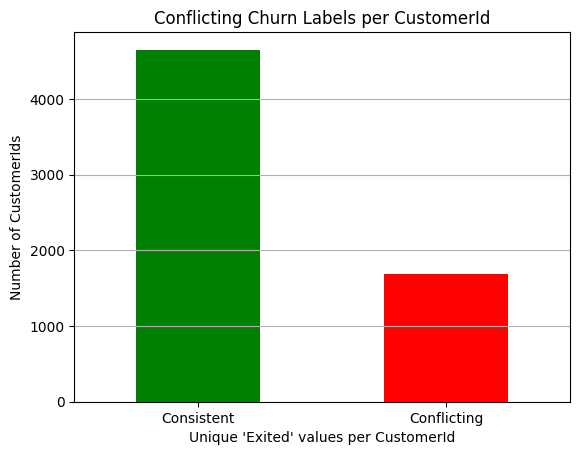

In [46]:
df = import_dataset(train_path)
# Check for duplicate CustomerId entries
duplicates = df[df.duplicated(subset='CustomerId', keep=False)]
print(f"Duplicate CustomerId: {len(duplicates)}")

# Display top 3 CustomerIds with the highest occurrence
customer_counts = df['CustomerId'].value_counts().reset_index()
customer_counts.columns = ['CustomerId', 'Count']
print(f"Unique CustomerIds: {len(customer_counts)}")
display(customer_counts.head(3))

# Display first 5 rows for the most common CustomerId
most_common_id = customer_counts.iloc[0]['CustomerId']
print(f"Entries for most common CustomerId:")
display(df[df['CustomerId'] == most_common_id].head())

# Plot conflicting churn labels for CustomerIds
conflict_counts = df.groupby("CustomerId")["Exited"].nunique().value_counts()
conflict_counts.plot(kind="bar", color=["green", "red"])
plt.title("Conflicting Churn Labels per CustomerId")
plt.xlabel("Unique 'Exited' values per CustomerId")
plt.ylabel("Number of CustomerIds")
plt.xticks([0, 1], ["Consistent", "Conflicting"], rotation=0)
plt.grid(axis='y')
plt.show()

## Target variable distribution

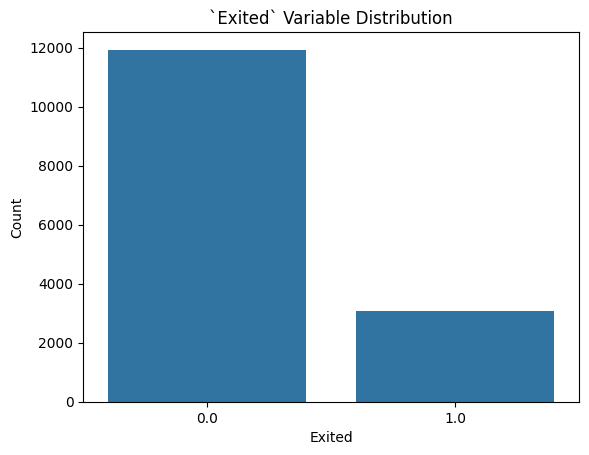

In [47]:
sns.countplot(x='Exited', data=df)
plt.title('`Exited` Variable Distribution')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.show()

### Class Distribution Insight

- The target variable `Exited` is notably imbalanced 80% stayed, 20% churned. Resampling of minority class might be appropriate.


## Features implication in churn probability

[train.csv] shape: (15000, 14)


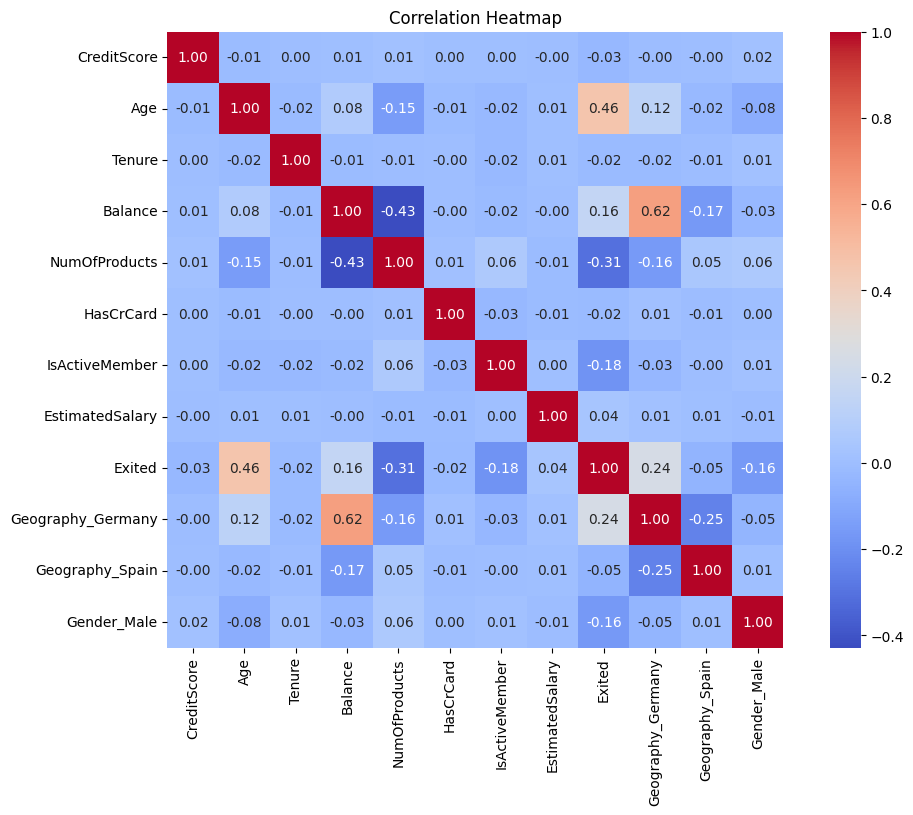

Categorical binary features: ['HasCrCard', 'IsActiveMember']
Categorical nominal features: ['Surname', 'Geography', 'Gender']
Numeric continuous features: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']
Skewness of numeric features:
 Age                0.855082
Balance            0.776598
NumOfProducts      0.106036
CreditScore        0.012390
Tenure            -0.001176
EstimatedSalary   -0.356943
dtype: float64 

Fraction of zeros in numeric features:
 CreditScore        0.000000
Age                0.000000
Tenure             0.025467
Balance            0.650133
EstimatedSalary    0.000000
NumOfProducts      0.000000
dtype: float64 



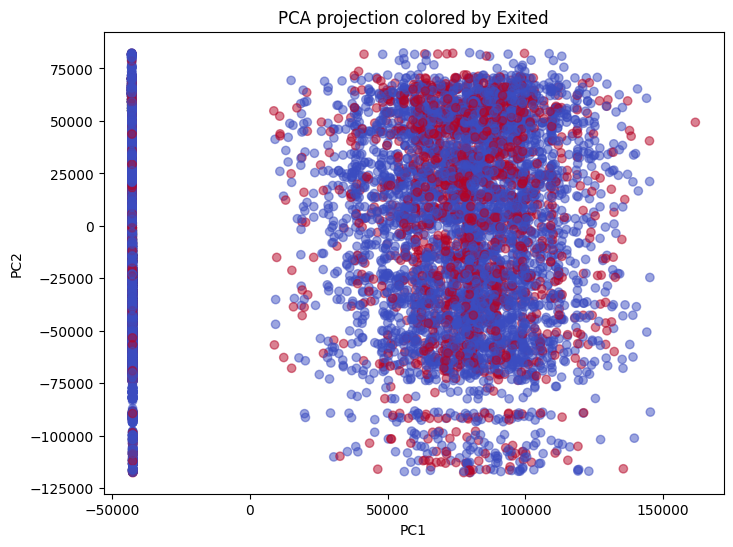

In [48]:
df = import_dataset(train_path)
def basic_preprocessing(df):
    df = df.drop(["id", "CustomerId", "Surname"], axis=1)  
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
    return df
df = basic_preprocessing(df)

# Correlation matrix
def heatmap(df):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Heatmap')
    plt.show()

heatmap(df)

# Feature types
categorical_binary = ["HasCrCard", "IsActiveMember"]
categorical_nominal = ["Surname", "Geography", "Gender"]
numeric_continuous = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary", "NumOfProducts"]
print("Categorical binary features:", categorical_binary)
print("Categorical nominal features:", categorical_nominal)
print("Numeric continuous features:", numeric_continuous)

# Skewness & zero-inflation
skewness = df[numeric_continuous].skew().sort_values(ascending=False)
zero_frac = (df[numeric_continuous] == 0).sum() / len(df)
print("Skewness of numeric features:\n", skewness, "\n")
print("Fraction of zeros in numeric features:\n", zero_frac, "\n")

# 2D PCA scatter
y = df.pop("Exited").values

pca = PCA(n_components=2)
proj = pca.fit_transform(df)
plt.figure(figsize=(8,6))
plt.scatter(proj[:, 0], proj[:, 1], c=y, cmap="coolwarm", alpha=0.5)
plt.title("PCA projection colored by Exited")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

## Balance and Churn Behavior

[train.csv] shape: (15000, 14)


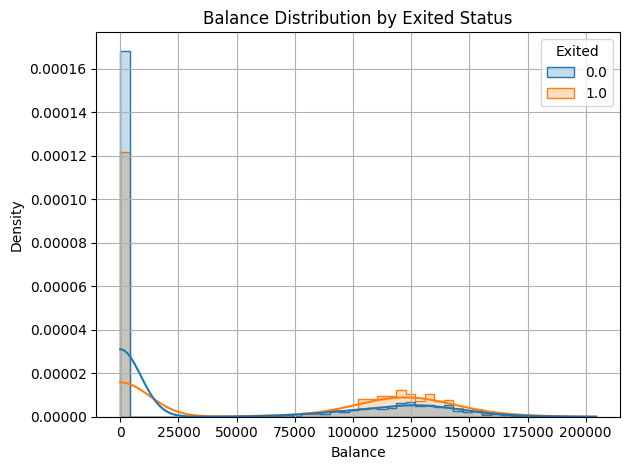

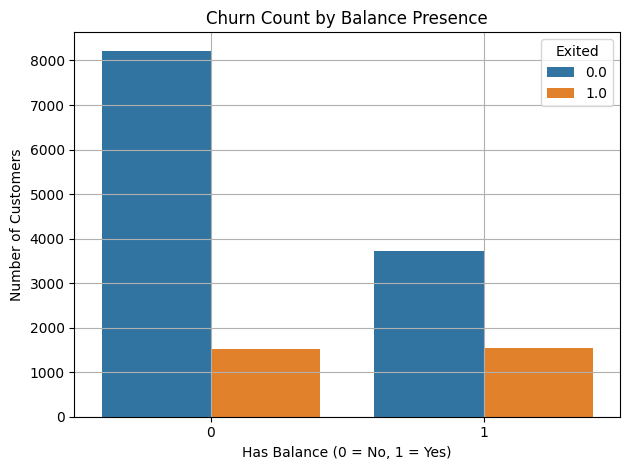

In [49]:
df = import_dataset(train_path)
# Balance variable distribution
sns.histplot(data=df, x="Balance", hue="Exited", bins=50, kde=True, element="step", stat="density", common_norm=False)
plt.title("Balance Distribution by Exited Status")
plt.xlabel("Balance")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

# Create HasBalance flag
df["HasBalance"] = (df["Balance"] > 0).astype(int)
sns.countplot(data=df, x="HasBalance", hue="Exited")
plt.title("Churn Count by Balance Presence")
plt.xlabel("Has Balance (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="max-width: 800px; line-height: 1.6;">
<p>
The barplot above compares the number of customers who have a positive account balance versus those with no balance at all, and how each group relates to churn (<code>Exited</code>).
</p>

<p>
Despite a significantly higher number of customers having a balance of zero, their churn rate appears lower. On the other hand, customers with a positive balance show a higher relative proportion of churners, even though they are fewer in absolute number.
</p>

<p>
This suggests that simply having money in the account does not imply loyalty, challenging the common assumption that more engaged customers are more likely to stay. Here, financial engagement might imply the opposite.
</p>

</div>


## Age and Churn Behavior

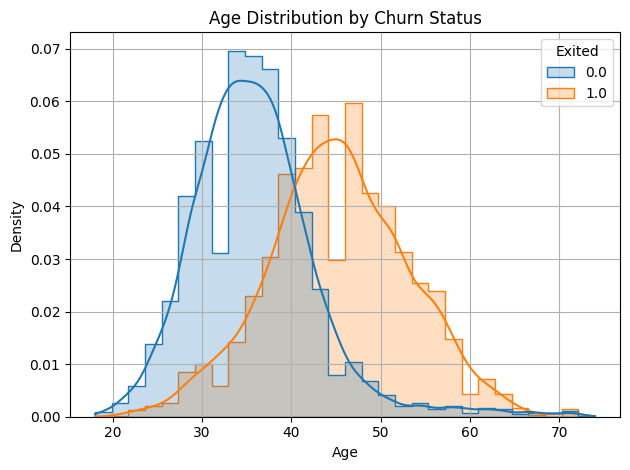

In [50]:
# Age distribution by churn status
sns.histplot(data=df, x="Age", hue="Exited", bins=30, kde=True, element="step", stat="density", common_norm=False)
plt.title("Age Distribution by Churn Status")
plt.xlabel("Age")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="max-width: 800px; line-height: 1.6;">
<p>
Churned customers are generally older, peaking around 40–50 years, while retained ones cluster around 30–35. This clear separation makes age a strong churn predictor, and motivates features like <code>IsSenior</code> or age group flags to capture the trend effectively.
</p>

</div>


## Geography and Churn Behavior

[train.csv] shape: (15000, 14)


Geography,France,Germany,Spain,All
Exited,,,,
0.0,7606,1580,2746,11932
1.0,1404,1121,543,3068
All,9010,2701,3289,15000


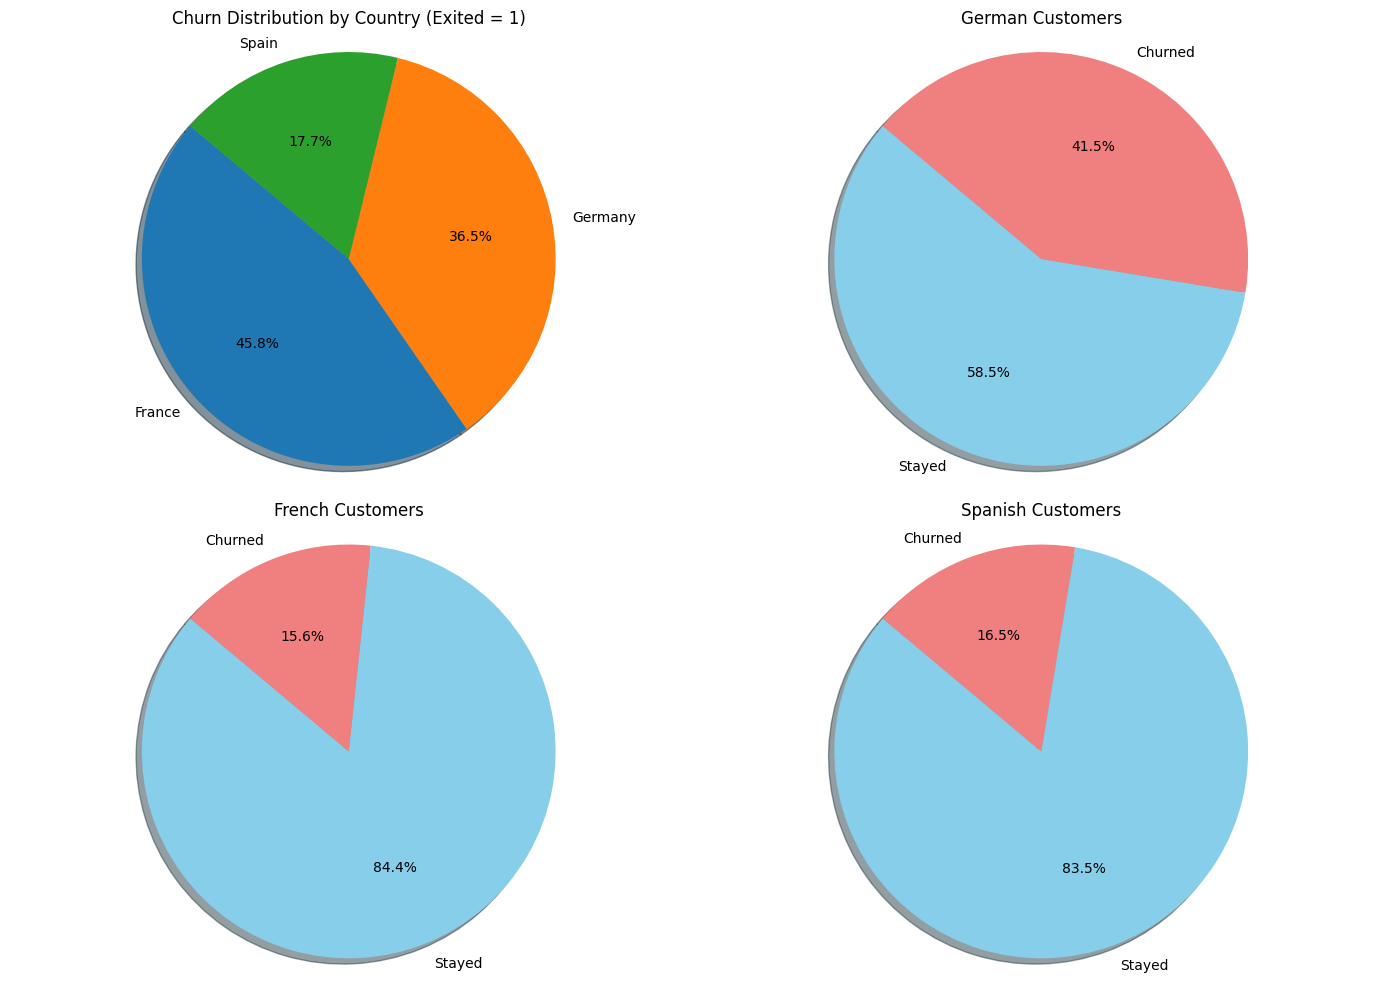

In [51]:
df = import_dataset(train_path)
display(pd.crosstab(df["Exited"], df["Geography"], margins=True))

# Prepare data for plots
churn_by_geo = df[df["Exited"] == 1]["Geography"].value_counts()
german_customers = df[df["Geography"] == "Germany"]
french_customers = df[df["Geography"] == "France"]
spanish_customers = df[df["Geography"] == "Spain"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1. Pie chart for churn distribution by country
axs[0, 0].pie(
    churn_by_geo,
    labels=churn_by_geo.index,
    autopct="%1.1f%%",
    startangle=140,
    shadow=True
)
axs[0, 0].set_title("Churn Distribution by Country (Exited = 1)")
axs[0, 0].axis('equal')

# 2. German customers churn pie
german_churn = german_customers["Exited"].value_counts().sort_index()
axs[0, 1].pie(
    german_churn,
    labels=["Stayed", "Churned"],
    autopct="%1.1f%%",
    startangle=140,
    colors=["skyblue", "lightcoral"],
    shadow=True
)
axs[0, 1].set_title("German Customers")
axs[0, 1].axis('equal')

# 3. French customers churn pie
french_churn = french_customers["Exited"].value_counts().sort_index()
axs[1, 0].pie(
    french_churn,
    labels=["Stayed", "Churned"],
    autopct="%1.1f%%",
    startangle=140,
    colors=["skyblue", "lightcoral"],
    shadow=True
)
axs[1, 0].set_title("French Customers")
axs[1, 0].axis('equal')

# 4. Spanish customers churn pie
spanish_churn = spanish_customers["Exited"].value_counts().sort_index()
axs[1, 1].pie(
    spanish_churn,
    labels=["Stayed", "Churned"],
    autopct="%1.1f%%",
    startangle=140,
    colors=["skyblue", "lightcoral"],
    shadow=True
)
axs[1, 1].set_title("Spanish Customers")
axs[1, 1].axis('equal')

plt.tight_layout()
plt.show()



<div style="max-width: 800px; line-height: 1.6;">
<p>
While France contributes the most to the absolute number of churned customers (due to its larger population), the churn rate among German customers is significantly higher — over 41%, compared to just 15–16% for France and Spain.
</p>

<p>
This highlights Germany as a high-risk region for churn, suggesting that customer nationality (or region) is a strong feature for prediction. It also motivates targeted retention strategies for the German segment.
</p>
</div>


## Gender and Churn Behavior

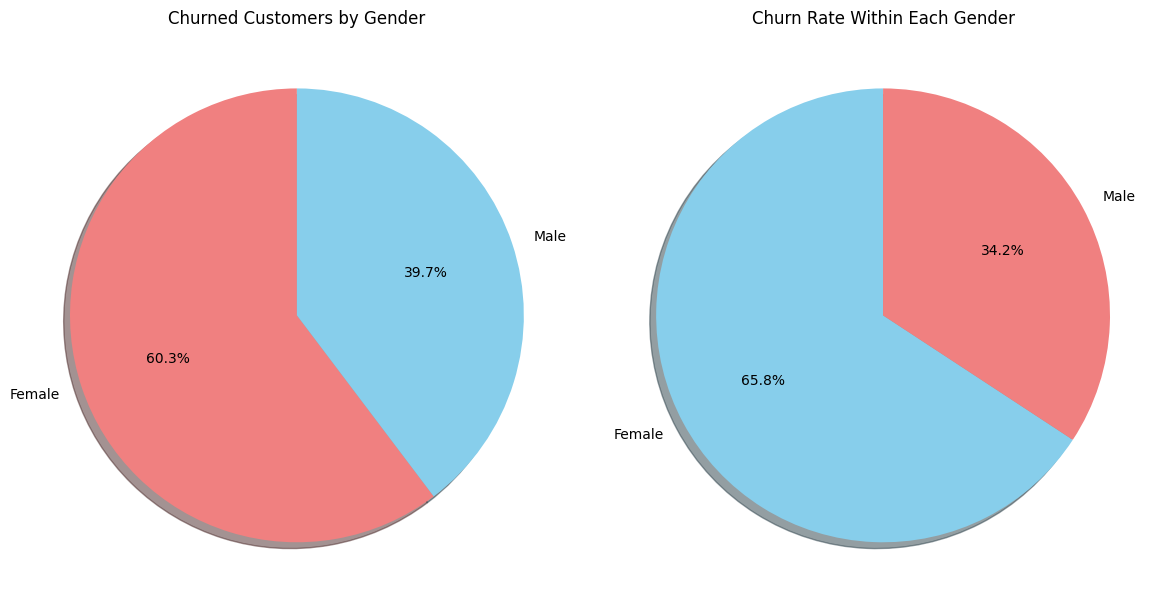

In [52]:
# Gender distribution by churn status
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart 1: Proportion of churned customers by gender
churned_by_gender = df[df["Exited"] == 1]["Gender"].value_counts()
axes[0].pie(churned_by_gender, labels=churned_by_gender.index, autopct="%1.1f%%", startangle=90, colors=["lightcoral", "skyblue"], shadow=True)
axes[0].set_title("Churned Customers by Gender")

# Pie chart 2: Churn rate within each gender group
gender_churn_rate = df.groupby("Gender")["Exited"].mean()
axes[1].pie(gender_churn_rate, labels=gender_churn_rate.index, autopct=lambda p: f"{p:.1f}%", startangle=90, colors=["skyblue", "lightcoral"], shadow=True)
axes[1].set_title("Churn Rate Within Each Gender")

plt.tight_layout()
plt.show()

## Number of Products and Churn Behavior

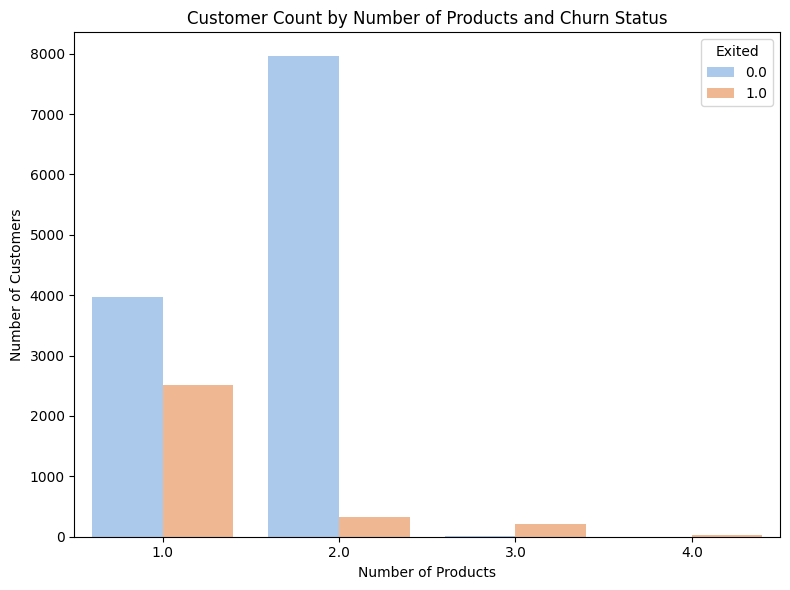

In [53]:
# Countplot of NumOfProducts by Exited status
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="NumOfProducts", hue="Exited", palette="pastel")
plt.title("Customer Count by Number of Products and Churn Status")
plt.xlabel("Number of Products")
plt.ylabel("Number of Customers")
plt.legend(title="Exited")
plt.tight_layout()
plt.show()


## Credit Score and Churn Behavior

[train.csv] shape: (15000, 14)


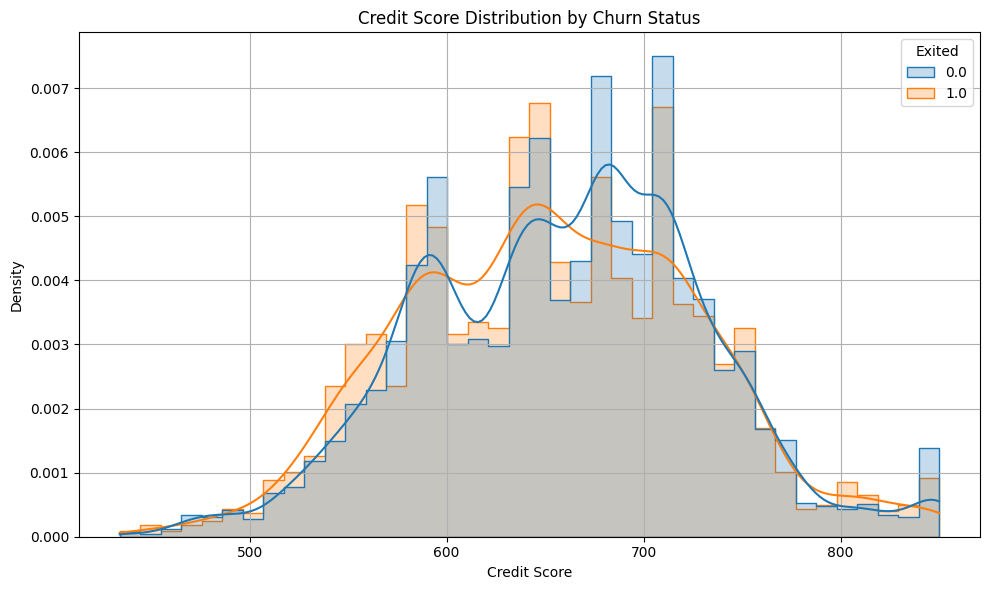

In [54]:
df = import_dataset(train_path)
# Plot Credit Score Distribution by Churn Status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="CreditScore", hue="Exited", bins=40, kde=True, element="step", stat="density", common_norm=False)
plt.title("Credit Score Distribution by Churn Status")
plt.xlabel("Credit Score")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="text-align: center">
    <h1>Model training & evaluation</h1>
</div>

## Constants

In [55]:
DROP_COLS = ['id', 'CustomerId', 'Surname']
CAT_COLS = ['Geography', 'Gender']
NUM_COLS = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
BIN_COLS = ['Age', 'Balance', 'EstimatedSalary']

## Helper functions

### Preprocessing

#### *Unscaled*
For models like Random Forest that don’t need scaling.  
Encodes categorical variables (`Geography`, `Gender`) using one-hot encoding and drops ID columns.  

In [56]:
def preprocess_unscaled(train_df, test_df):
    # Drop unnecessary columns
    test_ids = test_df['id'].copy()
    train_df.drop(DROP_COLS, axis=1, inplace=True)
    test_df.drop(DROP_COLS, axis=1, inplace=True)

    # One-hot encode categorical variables
    train_df = pd.get_dummies(train_df, columns=CAT_COLS, drop_first=True)
    test_df = pd.get_dummies(test_df, columns=CAT_COLS, drop_first=True)

    # Split the data into features and target variable
    X_train = train_df.drop('Exited', axis=1)
    y_train = train_df['Exited']
    X_test = test_df.reindex(columns=X_train.columns, fill_value=0)

    return X_train, y_train, X_test, test_ids

#### *Scaled*
For models like SVC or neural networks that require normalized input.

In [57]:
def preprocess_scaled(train_df, test_df):
    X_train, y_train, X_test, test_ids = preprocess_unscaled(train_df, test_df)

    # Scale numeric features
    scaler = StandardScaler()
    X_train[NUM_COLS] = scaler.fit_transform(X_train[NUM_COLS])
    X_test[NUM_COLS] = scaler.transform(X_test[NUM_COLS])

    return X_train, y_train, X_test, test_ids

#### *Regression*
Designed for logistic regression, using quantile binning and categorical encoding for linear compatibility.

In [58]:
def preprocess_linear(train_df, test_df):
    # Drop unnecessary columns
    drop_cols = ['id', 'CustomerId', 'Surname']
    test_ids = test_df['id'].copy()
    train_df.drop(drop_cols, axis=1, inplace=True)
    test_df.drop(drop_cols, axis=1, inplace=True)

    # Bin numeric columns using 10 quantiles
    bin_edges = {
        col: pd.qcut(train_df[col], q=10, retbins=True, duplicates='drop')[1]
        for col in BIN_COLS
    }

    for col in BIN_COLS: # Create bin columns
        train_df[f"{col}_bin"] = pd.cut(train_df[col], bins=bin_edges[col], labels=False, include_lowest=True)
        test_df[f"{col}_bin"] = pd.cut(test_df[col], bins=bin_edges[col], labels=False, include_lowest=True)
    
    # Convert NumOfProducts to categorical string for dummy encoding
    train_df["NumOfProducts_cat"] = train_df["NumOfProducts"].astype(str)
    test_df["NumOfProducts_cat"] = test_df["NumOfProducts"].astype(str)

    # One-hot encode all bin columns + NumOfProducts
    onehot_cols = [f"{col}_bin" for col in BIN_COLS] + ["NumOfProducts_cat", "Geography", "Gender"]
    train_df = pd.get_dummies(train_df, columns=onehot_cols, drop_first=False)
    test_df = pd.get_dummies(test_df, columns=onehot_cols, drop_first=False)

    # Drop original numerical columns
    train_df.drop(columns=BIN_COLS + ["NumOfProducts"], inplace=True)
    test_df.drop(columns=BIN_COLS + ["NumOfProducts"], inplace=True)

    # Split features and target in training data
    X_train = train_df.drop('Exited', axis=1)
    y_train = train_df['Exited']
    X_test = test_df.reindex(columns=X_train.columns, fill_value=0)
    
    return X_train, y_train, X_test, test_ids

#### *Validation of preprocessing*

In [59]:
def validate_split(X_train, X_test, y_train, test_ids):
    """Validates common aspects of train/test preprocessing"""
    issues = []
    if X_train.shape[1] != X_test.shape[1]:
        issues.append(f"Column mismatch: X_train has {X_train.shape[1]} columns, X_test has {X_test.shape[1]}.")

    if not X_train.columns.equals(X_test.columns):
        issues.append("Column names or order differ between X_train and X_test.")

    if X_train.shape[0] != len(y_train):
        issues.append(f"Row mismatch: X_train has {X_train.shape[0]} rows, y_train has {len(y_train)}.")

    if X_test.shape[0] != len(test_ids):
        issues.append(f"Row mismatch: X_test has {X_test.shape[0]} rows, test_ids has {len(test_ids)}.")

    if issues:
        print("Validation failed:")
        for issue in issues:
            print("-", issue)

### Model submission

In [ ]:
def make_submission(model, name, X_test, test_ids):
    """Predicts probabilities and saves submission file"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Build and save submission
    submission = pd.DataFrame({
        'id': test_ids,
        'Exited': y_pred_proba
    })
    submission = submission.sort_values('id')
    submission.to_csv(f"./predictions/{name}_submission.csv", index=False)
    print("Submission saved to 'submission.csv'.")
    display(submission.head(3))

## Model Evaluation

In [61]:
def evaluate_model(name, model, preprocess_fn):
    # 1) Load datasets
    train_df = import_dataset(train_path, v=False)
    test_df  = import_dataset(test_path,  v=False)

    # 2) Preprocess
    X_train, y_train, X_test, test_ids = preprocess_fn(train_df, test_df)
    validate_split(X_train, X_test, y_train, test_ids)

    # 3) Cross-validate
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    print(f"{name} CV ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

    # 4) Train final
    model.fit(X_train, y_train)
    make_submission(model, name, X_test, test_ids)
    return scores.mean()

## **Logistic Regression**
Logistic regression models the probability of class membership by fitting a linear decision boundary in a transformed (log-odds) space. It's efficient, interpretable, and performs well when input features are well-encoded.

In [62]:
# 1) Preprocess
train_df = import_dataset(train_path)
test_df  = import_dataset(test_path)
X_train, y_train, X_test, test_ids = preprocess_linear(train_df, test_df)

# 2) Param grid & search
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver="liblinear"), param_grid,
                    scoring="roc_auc", cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("LogReg best params:", grid.best_params_)

# 3) Build tuned model
best_logreg = LogisticRegression(**grid.best_params_, solver="liblinear")

# 4) Evaluate & submit
evaluate_model(
    name="Logistic_Regression",
    model=best_logreg,
    preprocess_fn=preprocess_linear
)

[train.csv] shape: (15000, 14)
[test.csv] shape: (10000, 13)
LogReg best params: {'C': 10}
Logistic_Regression CV ROC AUC: 0.9262 ± 0.0072
Submission saved to 'submission.csv'.


,id,Exited
0,15000,0.816878
1,15001,0.095572
2,15002,0.006550


np.float64(0.9262083447124985)

## **Random Forest**
- Train using k-fold cross-validation
- Find best param config using `RandomizedSearchCV`

In [63]:
# 1) Preprocess
train_df = import_dataset(train_path)
test_df  = import_dataset(test_path)
X_train, y_train, _, _ = preprocess_unscaled(train_df, test_df)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [0.3, 0.5],
    "class_weight": [None, "balanced"],
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist, 
    n_iter=30,
    scoring="roc_auc", 
    cv=skf, random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

print("Best AUC from RandomizedSearchCV: {:.4f}".format(random_search.best_score_))
print("Best parameters:", random_search.best_params_)

# 2) Build tuned model
best_params = random_search.best_params_
best_rf = RandomForestClassifier(**best_params, random_state=42)

# 3) Evaluate & submit
evaluate_model(
    name="Random_Forest",
    model=best_rf,
    preprocess_fn=preprocess_unscaled
)


[train.csv] shape: (15000, 14)
[test.csv] shape: (10000, 13)
Best AUC from RandomizedSearchCV: 0.9318
Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': 10, 'class_weight': None}
Random_Forest CV ROC AUC: 0.9318 ± 0.0074
Submission saved to 'submission.csv'.


,id,Exited
0,15000,0.853554
1,15001,0.036519
2,15002,0.033900


np.float64(0.9318275476552891)

## **SVC** (Support Vector Classifier)

To address class imbalance in the target variable, we apply oversampling to increase the  
representation of the minority class (Exited = 1) in the training data.

In [68]:
# 1) Preprocess
train_df = import_dataset(train_path)
test_df  = import_dataset(test_path)
X_train, y_train, X_test, test_ids = preprocess_scaled(train_df, test_df)

# 2) Scale features manually
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3) Define SVC with class weights
svc = SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42)

# 4) Define param grid
param_grid = {
    "C":     [0.1, 1],
    "gamma": [0.01, 0.1]
}

# 5) Grid search with ROC AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_scaled, y_train)

print("SVC best params:", grid.best_params_)

# 6) Evaluate
evaluate_model(
    name="SVC",
    model=grid.best_estimator_,
    preprocess_fn=preprocess_scaled 
)


[train.csv] shape: (15000, 14)
[test.csv] shape: (10000, 13)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
SVC best params: {'C': 0.1, 'gamma': 0.1}
SVC CV ROC AUC: 0.9260 ± 0.0090
Submission saved to 'submission.csv'.


,id,Exited
0,15000,0.795549
1,15001,0.032096
2,15002,0.024226


np.float64(0.9259674126847417)

## **Gradient Boosting**

In [65]:
# 1) Preprocess
train_df = import_dataset(train_path)
test_df  = import_dataset(test_path)
X_train, y_train, _, _ = preprocess_unscaled(train_df, test_df)

# 2) Param grid & search
param_grid = {
    "learning_rate": [0.1, 0.05],
    "n_estimators": [100, 200],
    "max_depth": [3, 5]
}
grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid, scoring="roc_auc", cv=5, n_jobs=-1
)
grid.fit(X_train, y_train)
print("GB best params:", grid.best_params_)

# 3) Build tuned model
best_gb = GradientBoostingClassifier(**grid.best_params_, random_state=42)

# 4) Evaluate & submit
evaluate_model(
    name="Gradient Boosting (tuned)",
    model=best_gb,
    preprocess_fn=preprocess_unscaled
)

[train.csv] shape: (15000, 14)
[test.csv] shape: (10000, 13)
GB best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Gradient Boosting (tuned) CV ROC AUC: 0.9334 ± 0.0075
Submission saved to 'submission.csv'.


,id,Exited
0,15000,0.884497
1,15001,0.036582
2,15002,0.034940


np.float64(0.9334337294349009)

## **Model Comparison**

In [66]:
# 1) Load raw data once
train_df = import_dataset(train_path)
test_df  = import_dataset(test_path)

# 2) Split train → train_val / validate (80/20 stratified)
X_full, y_full, _, _ = preprocess_linear(train_df, test_df)  # choose any; we only need X,y
X_tr, X_val, y_tr, y_val = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# 3) Define your tuned models
models = {
    "Logistic Regression": best_logreg,
    "Random Forest"      : best_rf,
    "SVC"                : best_svc_pipe,
    "Gradient Boosting"  : best_gb,
}

# 4) Fit on X_tr/y_tr, evaluate on X_val/y_val
rows = []
for name, model in models.items():
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    try:
        y_prob = model.predict_proba(X_val)[:,1]
    except:
        # For models without predict_proba (unlikely here), skip AUC
        y_prob = None

    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    auc  = roc_auc_score(y_val, y_prob) if y_prob is not None else float("nan")

    rows.append({
        "Model":    name,
        "Accuracy": f"{acc:.3f}",
        "Precision": f"{prec:.3f}",
        "Recall":    f"{rec:.3f}",
        "ROC AUC":   f"{auc:.3f}"
    })

# 5) Display comparison table
df_comp = pd.DataFrame(rows).set_index("Model")
display(df_comp)


[train.csv] shape: (15000, 14)
[test.csv] shape: (10000, 13)


,Accuracy,Precision,Recall,ROC AUC
Model,,,,
Logistic Regression,0.888,0.773,0.638,0.927
Random Forest,0.889,0.812,0.598,0.929
SVC,0.762,0.459,0.909,0.903
Gradient Boosting,0.891,0.792,0.632,0.930


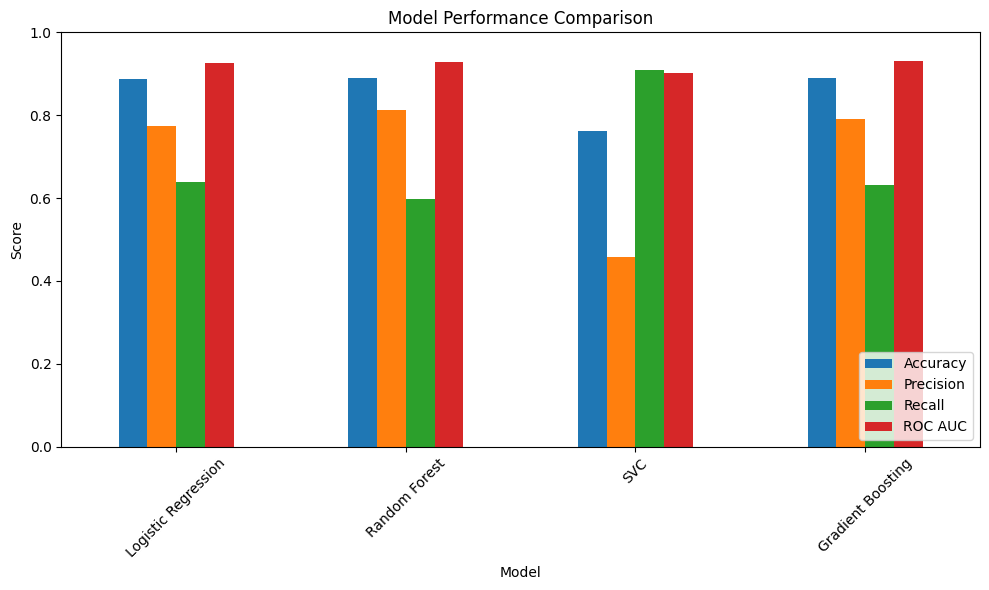

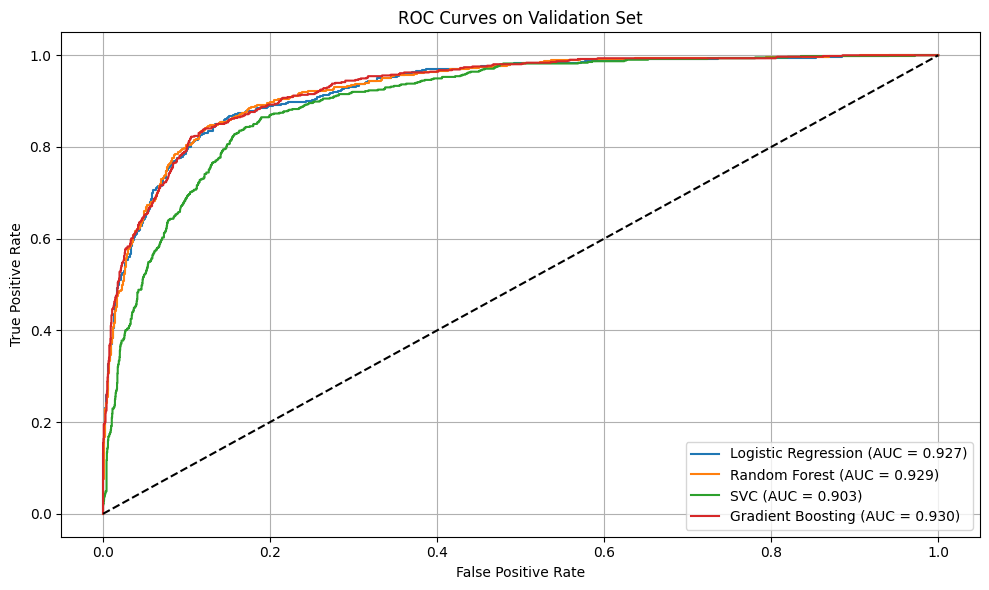

In [67]:
# 1. Bar chart of metrics
# Assuming df_comp is the DataFrame from the single-run comparison
plt.figure(figsize=(10, 6))
df_comp.astype(float).plot(
    kind='bar', ax=plt.gca()
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 2. ROC curves overlay
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_val, y_prob):.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves on Validation Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()